In [33]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
%matplotlib inline

### load datasets

In [34]:
%store -r train_data_formodel
data = train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques

tsne_dims_train = pd.read_csv('../dim_red_components/tsne_df_train.csv')
pca_dims_train = pd.read_csv('../dim_red_components/PC_df_train.csv')

## Univariate feature selection

### both train and test datasets are concatenated for the purposes of univariate feature selection

total_data = pd.concat([train_data[train_data.columns.values[8:-1]], test_data[test_data.columns.values[8:-1]]], axis = 0)

total_data.head()

### Features with a variance above a defined threshold are identified

my_variance_filter = VarianceThreshold(threshold=0.001)

high_variance_data = my_variance_filter.fit_transform(total_data)

high_variance_data_indexes = my_variance_filter.get_support()

high_variance_data_indexes

high_variance_col_names = total_data.columns.values[high_variance_data_indexes]

print(high_variance_col_names)

print('data shape before removal of low variance features')
print(total_data.shape)
print('data shape after removal of low variance features')
print(high_variance_data.shape)

# RFE, this isnt working yet, rankings all came out as 1

In [35]:
data.head()

,Analysis,Geology,Province,Region,Site,SubSite,Formation,Band,Nodule,Li7,Be9,B11,Mg24,Al27,Si28,P31,S33,K39,Ca42,Sc45,Ti47,V51,Cr52,Mn55,Fe56,Co59,Ni60,Cu63,Zn68,Ga69,Ge72,As75,Rb85,Sr88,Y89,Zr90,Nb93,Mo95,Cd111,In115,Sn118,Cs133,Ba137,La139,Ce140,Pr141,Nd146,Sm147,Eu153,Gd157,Tb159,Dy163,Ho165,Er166,Tm169,Yb172,Lu175,Hf178,Ta181,Pb208,Th232,U238,class
0,10_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,15.63,0.12,48.36,33.359881,943.71,464944.180000,50.280000,538.57,455.94,712.39,0.42,15.58,0.27,3.30,0.69,8.46,0.05,0.80,1.62,10.82,0.25,1.22,0.16,0.43,12.94,0.88,1.51,0.09,0.05,0.02,0.00,0.05,0.01,6.54,0.84,0.95,0.23,0.87,0.16,0.04,0.16,0.02,0.11,0.03,0.06,0.01,0.02,0.00,0.04,0.01,0.24,0.07,0.05,0
1,11_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,11.50,0.09,44.77,33.359881,1077.11,465010.940000,70.910000,438.20,387.82,515.24,0.44,18.47,0.29,3.45,1.01,11.59,0.11,0.36,0.53,8.93,0.34,0.85,0.10,0.45,13.22,0.95,1.74,0.07,0.01,0.02,0.00,0.04,0.02,8.04,0.92,1.01,0.23,0.98,0.18,0.04,0.18,0.02,0.13,0.03,0.06,0.01,0.04,0.01,0.05,0.00,0.07,0.08,0.04,0
2,12_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,20.05,0.06,44.88,42.700000,620.21,465295.410000,104.470000,372.66,363.71,957.89,0.76,19.89,0.55,3.25,1.21,87.99,0.21,1.68,1.53,11.98,0.25,1.71,0.13,0.43,8.52,0.87,0.93,0.10,0.02,0.02,0.00,0.05,0.01,3.13,0.90,1.08,0.26,0.84,0.15,0.04,0.19,0.02,0.14,0.02,0.07,0.01,0.06,0.00,0.02,0.01,0.46,0.05,0.05,0
3,13_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,11.16,0.73,47.06,33.359881,1143.19,462284.527976,2309.325714,1075.89,547.55,2174.30,0.43,42.30,0.67,152.42,4.84,145.34,0.30,2.45,5.02,17.15,0.35,2.13,0.84,0.76,13.16,0.97,2.00,0.10,0.29,0.18,0.01,0.78,0.04,8.74,0.93,0.95,0.21,0.75,0.13,0.04,0.25,0.02,0.09,0.03,0.05,0.00,0.03,0.00,0.08,0.00,0.64,0.05,0.03,0
4,14_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,17.71,0.32,48.26,33.520000,547.22,465027.110000,44.440000,464.78,278.25,1551.63,0.71,11.18,0.27,2.56,1.73,25.38,0.05,0.80,0.55,9.80,0.41,1.41,0.12,0.28,9.90,0.90,0.90,0.08,0.04,0.10,0.00,0.09,0.01,2.74,0.97,1.09,0.27,1.00,0.17,0.04,0.19,0.02,0.15,0.03,0.05,0.01,0.05,0.01,0.02,0.01,0.59,0.06,0.09,0


### Recursive feature elimination with cross-validation is done using a random forest as the estimator 

In [36]:
my_rfc = RandomForestClassifier(n_estimators=2000, n_jobs=-1)



In [37]:
my_rfc_selector = RFECV(estimator=my_rfc, step=1, cv=StratifiedKFold(3), verbose=2, scoring='f1_macro')

In [38]:
data.columns.values[9:-1]

array(['Li7', 'Be9', 'B11', 'Mg24', 'Al27', 'Si28', 'P31', 'S33', 'K39',
       'Ca42', 'Sc45', 'Ti47', 'V51', 'Cr52', 'Mn55', 'Fe56', 'Co59',
       'Ni60', 'Cu63', 'Zn68', 'Ga69', 'Ge72', 'As75', 'Rb85', 'Sr88',
       'Y89', 'Zr90', 'Nb93', 'Mo95', 'Cd111', 'In115', 'Sn118', 'Cs133',
       'Ba137', 'La139', 'Ce140', 'Pr141', 'Nd146', 'Sm147', 'Eu153',
       'Gd157', 'Tb159', 'Dy163', 'Ho165', 'Er166', 'Tm169', 'Yb172',
       'Lu175', 'Hf178', 'Ta181', 'Pb208', 'Th232', 'U238'], dtype=object)

data = pd.concat([data, tsne_dims_train, pca_dims_train[['PC1', 'PC2', 'PC3']]], axis = 1)

In [39]:
data.head()

,Analysis,Geology,Province,Region,Site,SubSite,Formation,Band,Nodule,Li7,Be9,B11,Mg24,Al27,Si28,P31,S33,K39,Ca42,Sc45,Ti47,V51,Cr52,Mn55,Fe56,Co59,Ni60,Cu63,Zn68,Ga69,Ge72,As75,Rb85,Sr88,Y89,Zr90,Nb93,Mo95,Cd111,In115,Sn118,Cs133,Ba137,La139,Ce140,Pr141,Nd146,Sm147,Eu153,Gd157,Tb159,Dy163,Ho165,Er166,Tm169,Yb172,Lu175,Hf178,Ta181,Pb208,Th232,U238,class
0,10_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,15.63,0.12,48.36,33.359881,943.71,464944.180000,50.280000,538.57,455.94,712.39,0.42,15.58,0.27,3.30,0.69,8.46,0.05,0.80,1.62,10.82,0.25,1.22,0.16,0.43,12.94,0.88,1.51,0.09,0.05,0.02,0.00,0.05,0.01,6.54,0.84,0.95,0.23,0.87,0.16,0.04,0.16,0.02,0.11,0.03,0.06,0.01,0.02,0.00,0.04,0.01,0.24,0.07,0.05,0
1,11_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,11.50,0.09,44.77,33.359881,1077.11,465010.940000,70.910000,438.20,387.82,515.24,0.44,18.47,0.29,3.45,1.01,11.59,0.11,0.36,0.53,8.93,0.34,0.85,0.10,0.45,13.22,0.95,1.74,0.07,0.01,0.02,0.00,0.04,0.02,8.04,0.92,1.01,0.23,0.98,0.18,0.04,0.18,0.02,0.13,0.03,0.06,0.01,0.04,0.01,0.05,0.00,0.07,0.08,0.04,0
2,12_FH1_1_1,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_1,20.05,0.06,44.88,42.700000,620.21,465295.410000,104.470000,372.66,363.71,957.89,0.76,19.89,0.55,3.25,1.21,87.99,0.21,1.68,1.53,11.98,0.25,1.71,0.13,0.43,8.52,0.87,0.93,0.10,0.02,0.02,0.00,0.05,0.01,3.13,0.90,1.08,0.26,0.84,0.15,0.04,0.19,0.02,0.14,0.02,0.07,0.01,0.06,0.00,0.02,0.01,0.46,0.05,0.05,0
3,13_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,11.16,0.73,47.06,33.359881,1143.19,462284.527976,2309.325714,1075.89,547.55,2174.30,0.43,42.30,0.67,152.42,4.84,145.34,0.30,2.45,5.02,17.15,0.35,2.13,0.84,0.76,13.16,0.97,2.00,0.10,0.29,0.18,0.01,0.78,0.04,8.74,0.93,0.95,0.21,0.75,0.13,0.04,0.25,0.02,0.09,0.03,0.05,0.00,0.03,0.00,0.08,0.00,0.64,0.05,0.03,0
4,14_FH1_1_2,Bedrock,Northern,NaN,FH,FH1,Burnham,FH1,FH1_1_2,17.71,0.32,48.26,33.520000,547.22,465027.110000,44.440000,464.78,278.25,1551.63,0.71,11.18,0.27,2.56,1.73,25.38,0.05,0.80,0.55,9.80,0.41,1.41,0.12,0.28,9.90,0.90,0.90,0.08,0.04,0.10,0.00,0.09,0.01,2.74,0.97,1.09,0.27,1.00,0.17,0.04,0.19,0.02,0.15,0.03,0.05,0.01,0.05,0.01,0.02,0.01,0.59,0.06,0.09,0


In [40]:
X = data[data.columns.values[9:-1]]
y = data['class']

In [41]:
print(X.shape)
print(y.shape)

(1233, 53)
(1233,)


In [42]:
selector = my_rfc_selector.fit(X, y)

Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 fe

/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fitting estimator with 2 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 fea

### The number of features with the best macro f1 score


In [43]:
my_rfc_selector.ranking_
feat_ranks = pd.DataFrame(data = {'features': data.columns.values[9:-1], 'rfe ranking': my_rfc_selector.ranking_} )


In [44]:
feat_ranks

,features,rfe ranking
0,Li7,1
1,Be9,7
2,B11,1
3,Mg24,1
4,Al27,1
5,Si28,1
6,P31,1
7,S33,1
8,K39,1
9,Ca42,1


In [45]:
my_rfc_selector.n_features_

37

### macro-f1 score is plotted against number of features

In [46]:
RFCV_df = pd.DataFrame(data = {'no_features' : range(1, len(my_rfc_selector.grid_scores_) + 1), 'scores': my_rfc_selector.grid_scores_})

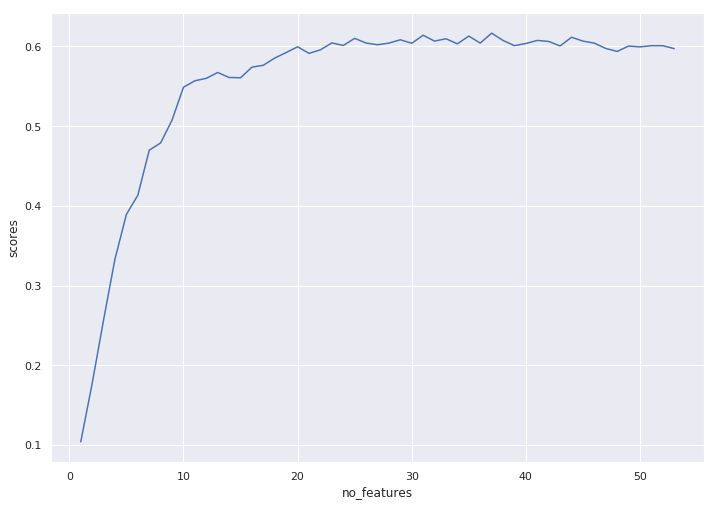

In [47]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data = RFCV_df, x = 'no_features', y = 'scores')

### The best features are defined

In [48]:
best_feats = my_rfc_selector.get_support()

In [49]:
best_feats = data.columns.values[9:-1][best_feats]
best_feats

array(['Li7', 'B11', 'Mg24', 'Al27', 'Si28', 'P31', 'S33', 'K39', 'Ca42',
       'Sc45', 'Ti47', 'V51', 'Cr52', 'Mn55', 'Fe56', 'Ni60', 'Cu63',
       'Zn68', 'Ga69', 'Ge72', 'As75', 'Rb85', 'Sr88', 'Y89', 'Zr90',
       'Nb93', 'Cd111', 'Sn118', 'Ba137', 'La139', 'Ce140', 'Pr141',
       'Nd146', 'Sm147', 'Gd157', 'Pb208', 'U238'], dtype=object)

In [50]:
%store best_feats

Stored 'best_feats' (ndarray)
